# Lab: Regularizing MLPs


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this lab, you'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping and dropout.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Lets take a look to the mini-batch size and plot a sample.

In [4]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

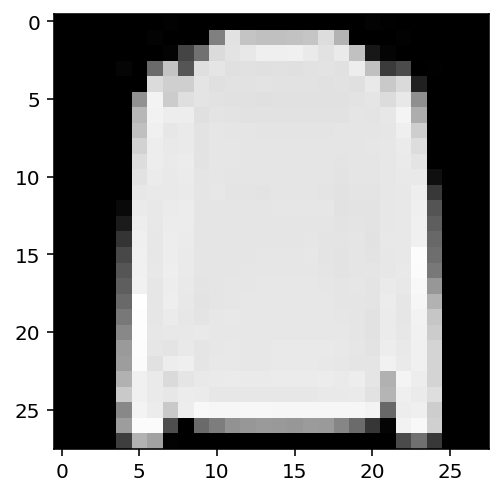

In [5]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [6]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels=10): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

In [7]:
class MLP_extended(MLP):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [8]:
my_MLP = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=20,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Training loss after 0 epochs: 0.539460
Training loss after 1 epochs: 0.377450
Training loss after 2 epochs: 0.339511
Training loss after 3 epochs: 0.316035
Training loss after 4 epochs: 0.294492
Training loss after 5 epochs: 0.277448
Training loss after 6 epochs: 0.263898
Training loss after 7 epochs: 0.252434
Training loss after 8 epochs: 0.242968
Training loss after 9 epochs: 0.228977
Training loss after 10 epochs: 0.221347
Training loss after 11 epochs: 0.210336
Training loss after 12 epochs: 0.201531
Training loss after 13 epochs: 0.193337
Training loss after 14 epochs: 0.187045
Training loss after 15 epochs: 0.176589
Training loss after 16 epochs: 0.171944
Training loss after 17 epochs: 0.164047
Training loss after 18 epochs: 0.157541
Training loss after 19 epochs: 0.152150
Training loss after 20 epochs: 0.148003
Training loss after 21 epochs: 0.140658
Training loss after 22 epochs: 0.134405
Training loss after 23 epochs: 0.132926
Training loss after 24 epochs: 0.125792
Training l

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [9]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



In [10]:
torch.__version__

'1.8.1'

> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs.  Compute the final train/validation/test performance.

In [11]:
class MLP_extended2(MLP):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images.view(images.shape[0], -1))

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [12]:
my_MLP = MLP_extended2(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.561399, Validation loss: 0.445877
Epoch 1. Training loss: 0.391631, Validation loss: 0.407429
Epoch 2. Training loss: 0.353804, Validation loss: 0.382732
Epoch 3. Training loss: 0.324754, Validation loss: 0.363887
Epoch 4. Training loss: 0.303142, Validation loss: 0.348466
Epoch 5. Training loss: 0.288563, Validation loss: 0.325943
Epoch 6. Training loss: 0.271702, Validation loss: 0.335514
Epoch 7. Training loss: 0.257519, Validation loss: 0.319807
Epoch 8. Training loss: 0.247585, Validation loss: 0.337604
Epoch 9. Training loss: 0.234955, Validation loss: 0.339619
Epoch 10. Training loss: 0.226219, Validation loss: 0.378434
Epoch 11. Training loss: 0.212769, Validation loss: 0.333785
Epoch 12. Training loss: 0.205155, Validation loss: 0.329153
Epoch 13. Training loss: 0.195039, Validation loss: 0.340738
Epoch 14. Training loss: 0.189699, Validation loss: 0.349147
Epoch 15. Training loss: 0.177190, Validation loss: 0.348659
Epoch 16. Training loss: 0.172609,

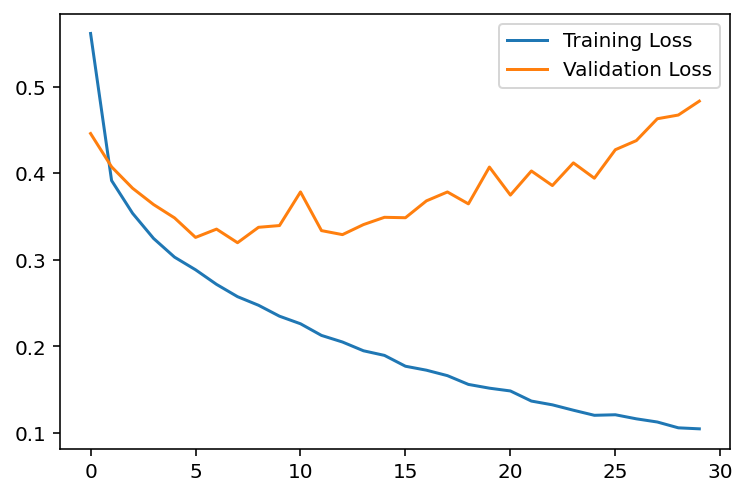

In [13]:
plt.plot(my_MLP.loss_during_training,label='Training Loss')
plt.plot(my_MLP.valid_loss_during_training,label='Validation Loss')
plt.legend()

In [14]:
print(my_MLP.eval_performance(trainloader))
print(my_MLP.eval_performance(validloader))
print(my_MLP.eval_performance(testloader))

tensor(0.9670)
tensor(0.8922)
tensor(0.8843)


If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [15]:
my_MLP = MLP_extended2(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=5,lr=1e-3)

my_MLP.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.553834, Validation loss: 0.423090
Epoch 1. Training loss: 0.391948, Validation loss: 0.409146
Epoch 2. Training loss: 0.351631, Validation loss: 0.347314
Epoch 3. Training loss: 0.324035, Validation loss: 0.372622
Epoch 4. Training loss: 0.304519, Validation loss: 0.333733


In [16]:
print(my_MLP.eval_performance(trainloader))
print(my_MLP.eval_performance(validloader))
print(my_MLP.eval_performance(testloader))

tensor(0.8995)
tensor(0.8787)
tensor(0.8702)


## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modify the extended class to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [17]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)   
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output4(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

In [18]:
class MLPdrop_extended(MLPdrop):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,prob)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # set model back to train mode
        self.train()
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images.view(images.shape[0], -1))

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            # set model back to train mode
            self.train()
                    
            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            # set model to evaluation mode
            self.eval()

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [19]:
my_MLP_drop = MLPdrop_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3,prob=0.1)

my_MLP_drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.587182, Validation loss: 0.490225
Epoch 1. Training loss: 0.416230, Validation loss: 0.392995
Epoch 2. Training loss: 0.379301, Validation loss: 0.360530
Epoch 3. Training loss: 0.357193, Validation loss: 0.352555
Epoch 4. Training loss: 0.338357, Validation loss: 0.345258
Epoch 5. Training loss: 0.319132, Validation loss: 0.346319
Epoch 6. Training loss: 0.307871, Validation loss: 0.330580
Epoch 7. Training loss: 0.296124, Validation loss: 0.322379
Epoch 8. Training loss: 0.284842, Validation loss: 0.321688
Epoch 9. Training loss: 0.274067, Validation loss: 0.322204
Epoch 10. Training loss: 0.269126, Validation loss: 0.336843
Epoch 11. Training loss: 0.258007, Validation loss: 0.322582
Epoch 12. Training loss: 0.249678, Validation loss: 0.329584
Epoch 13. Training loss: 0.246699, Validation loss: 0.333121
Epoch 14. Training loss: 0.238636, Validation loss: 0.330687
Epoch 15. Training loss: 0.232091, Validation loss: 0.333322
Epoch 16. Training loss: 0.227025,

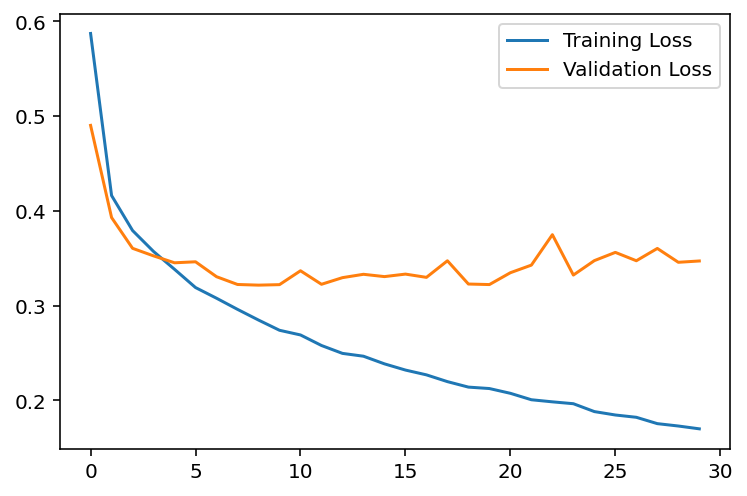

In [20]:
plt.plot(my_MLP_drop.loss_during_training,label='Training Loss')
plt.plot(my_MLP_drop.valid_loss_during_training,label='Validation Loss')
plt.legend()

In [21]:
print(my_MLP_drop.eval_performance(trainloader))
print(my_MLP_drop.eval_performance(validloader))
print(my_MLP_drop.eval_performance(testloader))

tensor(0.9533)
tensor(0.8930)
tensor(0.8908)


In [22]:
my_MLP_drop = MLPdrop_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3,prob=0.3)

my_MLP_drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.697892, Validation loss: 0.460693
Epoch 1. Training loss: 0.488795, Validation loss: 0.402100
Epoch 2. Training loss: 0.445944, Validation loss: 0.387082
Epoch 3. Training loss: 0.421520, Validation loss: 0.373798
Epoch 4. Training loss: 0.400343, Validation loss: 0.363111
Epoch 5. Training loss: 0.383524, Validation loss: 0.359648
Epoch 6. Training loss: 0.375826, Validation loss: 0.348938
Epoch 7. Training loss: 0.361298, Validation loss: 0.342966
Epoch 8. Training loss: 0.354673, Validation loss: 0.345386
Epoch 9. Training loss: 0.340715, Validation loss: 0.328386
Epoch 10. Training loss: 0.335045, Validation loss: 0.333260
Epoch 11. Training loss: 0.332631, Validation loss: 0.324683
Epoch 12. Training loss: 0.326670, Validation loss: 0.340108
Epoch 13. Training loss: 0.318952, Validation loss: 0.326986
Epoch 14. Training loss: 0.313426, Validation loss: 0.324461
Epoch 15. Training loss: 0.307041, Validation loss: 0.332417
Epoch 16. Training loss: 0.307015,

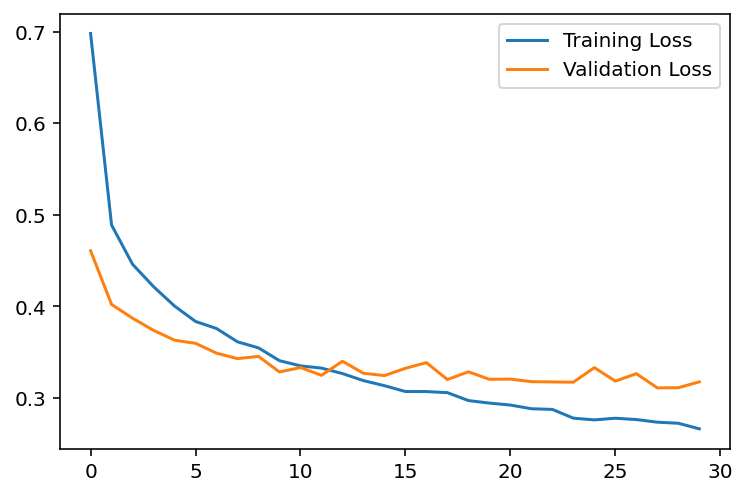

In [23]:
plt.plot(my_MLP_drop.loss_during_training,label='Training Loss')
plt.plot(my_MLP_drop.valid_loss_during_training,label='Validation Loss')
plt.legend()

In [24]:
print(my_MLP_drop.eval_performance(trainloader))
print(my_MLP_drop.eval_performance(validloader))
print(my_MLP_drop.eval_performance(testloader))

tensor(0.9295)
tensor(0.8894)
tensor(0.8867)
